# Arbitrary TTD tails computation and convolution with a sine wave input signal
Each arbitrary tails is computed from gamma distributions, whose quantile value at the threshold age is equal to the quantile value of the reference TTD. The difference between the probability density function of the reference and arbitrary TTD at the treshold age must lie within a a pre-defined tolerance. 
The tracers considered here are stable water isotopes, more specifically oxygen-18 (expressed in delta notation $\delta^{18}O$ [‰]), an is represented as a pure sine-wave.

In [ ]:
# Load necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import random

from helpers import sine_wave, find_gamma_parameters, find_nearest_greater

In [2]:
# General constant
num_days_in_year = 365.25

# Define properties of the input tracer concentration
num_years_spinup_Cin = 96  # number of spinup years before comupting critical age
spinup_Cin_len = int(num_years_spinup_Cin * num_days_in_year)  # in days
timesteps = np.arange(spinup_Cin_len)

A_p = 3  # amplitude of the sine-wave (in ‰ delta 18O)
freq = 1 / num_days_in_year  # frequency of the sine-wave
phase = -.82  # phase shift of the sine-wave (has no effect on the critical age)
k_p = -9.12  # vertical offset of the tracer signal (has no effect on the critical age)

spinup_Cin = sine_wave(timesteps, A=A_p, f=freq, phi=phase, C=k_p)
evaluation_Cin = sine_wave(np.arange(int(num_days_in_year)), A=A_p, f=freq, phi=phase, C=k_p)

overall_Cin = np.concatenate([spinup_Cin, evaluation_Cin])  # includes the spinup period and evaluation period input concentrations
overall_timesteps = np.arange(len(overall_Cin))

# Define the relevant uncertainty
sigma_p = 0.1

In [3]:
threshold_age = 400

# Reference gamma TTD properties
timesteps_gamma = np.arange(spinup_Cin_len + 1)  # the pdf will be as long as the spinup period
alpha_ref = .5
tau_bar_ref = 1 * num_days_in_year
cdf_values_ref = scipy.stats.gamma.cdf(timesteps_gamma, a=alpha_ref, scale=tau_bar_ref/alpha_ref)
gamma_TTD_ref = np.diff(cdf_values_ref)

# Arbitrary tails properties
alpha_range = [0.2, 10]
tau_bar_range = np.array([.5, 20])  # in years, conversion to days inside function
num_tails = 1000

# Age array
agesteps = np.arange(spinup_Cin_len)

# Timesteps for gamma TTD of tail
timesteps_gamma_double = np.arange(2*spinup_Cin_len + 1)

# Initialize arrays
piecewise_TTD = np.zeros([num_tails, spinup_Cin_len])
piecewise_TTD_AuC = np.zeros(num_tails)
piecewise_MTT = np.zeros(num_tails)
piecewise_TTD_tail_params = np.zeros([num_tails, 2])
Cout_infered_tail = np.zeros([num_tails, int(num_days_in_year)])

# Compute the reference Cout over one period right after spinup
Cout_true_one_period = np.zeros(int(1 * num_days_in_year))

for j in range(int(1 * num_days_in_year)):
    Cout_true_one_period[j] = np.dot(overall_Cin[j:spinup_Cin_len+j][::-1], gamma_TTD_ref)

# Compute and select arbitrary TTD tails
matching_params = find_gamma_parameters(p_target=gamma_TTD_ref[threshold_age], q_target=cdf_values_ref[threshold_age+1],
                                        alpha_range=alpha_range, tau_bar_range=tau_bar_range,
                                        step_size=.1, tolerance=0.001)
if len(matching_params) < num_tails:
    raise ValueError('Not enough gamma distributions fit the tail of the TTD')

matching_params = random.sample(matching_params, num_tails)

for l, gamma_params in enumerate(matching_params):
    tail_of_TTD_cdf = scipy.stats.gamma.cdf(timesteps_gamma_double, a=gamma_params[0], scale=gamma_params[1]/gamma_params[0])
    index_ta_quantile = find_nearest_greater(tail_of_TTD_cdf, cdf_values_ref[threshold_age+1])
    tail_of_TTD = np.diff(tail_of_TTD_cdf[index_ta_quantile:index_ta_quantile+1+spinup_Cin_len-threshold_age])
    
    piecewise_TTD_loc = np.concatenate([gamma_TTD_ref[:threshold_age], tail_of_TTD])
    piecewise_TTD[l, :] = piecewise_TTD_loc
    piecewise_MTT[l] = np.sum(agesteps * piecewise_TTD[l, :])
    piecewise_TTD_tail_params[l, 0], piecewise_TTD_tail_params[l, 1] = gamma_params
    piecewise_TTD_AuC[l] = np.sum(piecewise_TTD_loc)

    # Cout computations for TTD with arbitrary tail
    Cout_thresh_local = np.zeros(1 * int(num_days_in_year))
    piecewise_TTD_loc_rev = piecewise_TTD_loc[::-1]

    for t in range(1 * int(num_days_in_year)):
        Cout_thresh_local[t] = np.dot(overall_Cin[t:spinup_Cin_len+t], piecewise_TTD_loc_rev)
    
    Cout_infered_tail[l, :] = Cout_thresh_local

In [4]:
# Search for suitable tails, should integrate to unity over the spinup period
# to avoid mass conservation issues
suitable_tails = np.zeros(num_tails)

for l in range(num_tails):
    if piecewise_TTD_AuC[l] > 0.999:
        suitable_tails[l] = 1

In [5]:
# Select N suitable tails, based on wished MTTs (for plotting esthetics)
num_tails_plot = 10
wished_MTTs = np.linspace(280, 900, num_tails_plot)  # interval of MTTs
idx_tails_plot = np.zeros(num_tails_plot)

for n in range(num_tails_plot):
    objective_MTT_range = np.array([wished_MTTs - 25, wished_MTTs + 15])
    suitable_tails_idx_temp = []

    for j in range(num_tails):
        if suitable_tails[j] == 1 and piecewise_MTT[j] <= objective_MTT_range[1, n] and piecewise_MTT[j] >= objective_MTT_range[0, n]:
            suitable_tails_idx_temp.append(j)
        
    idx_tails_plot[n] = random.sample(suitable_tails_idx_temp, 1)[0]

idx_tails_plot = idx_tails_plot.astype(int)

/var/folders/0d/p4ksqqfx7dz8kb80bdxnksbr0000gp/T/ipykernel_44769/2676140075.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


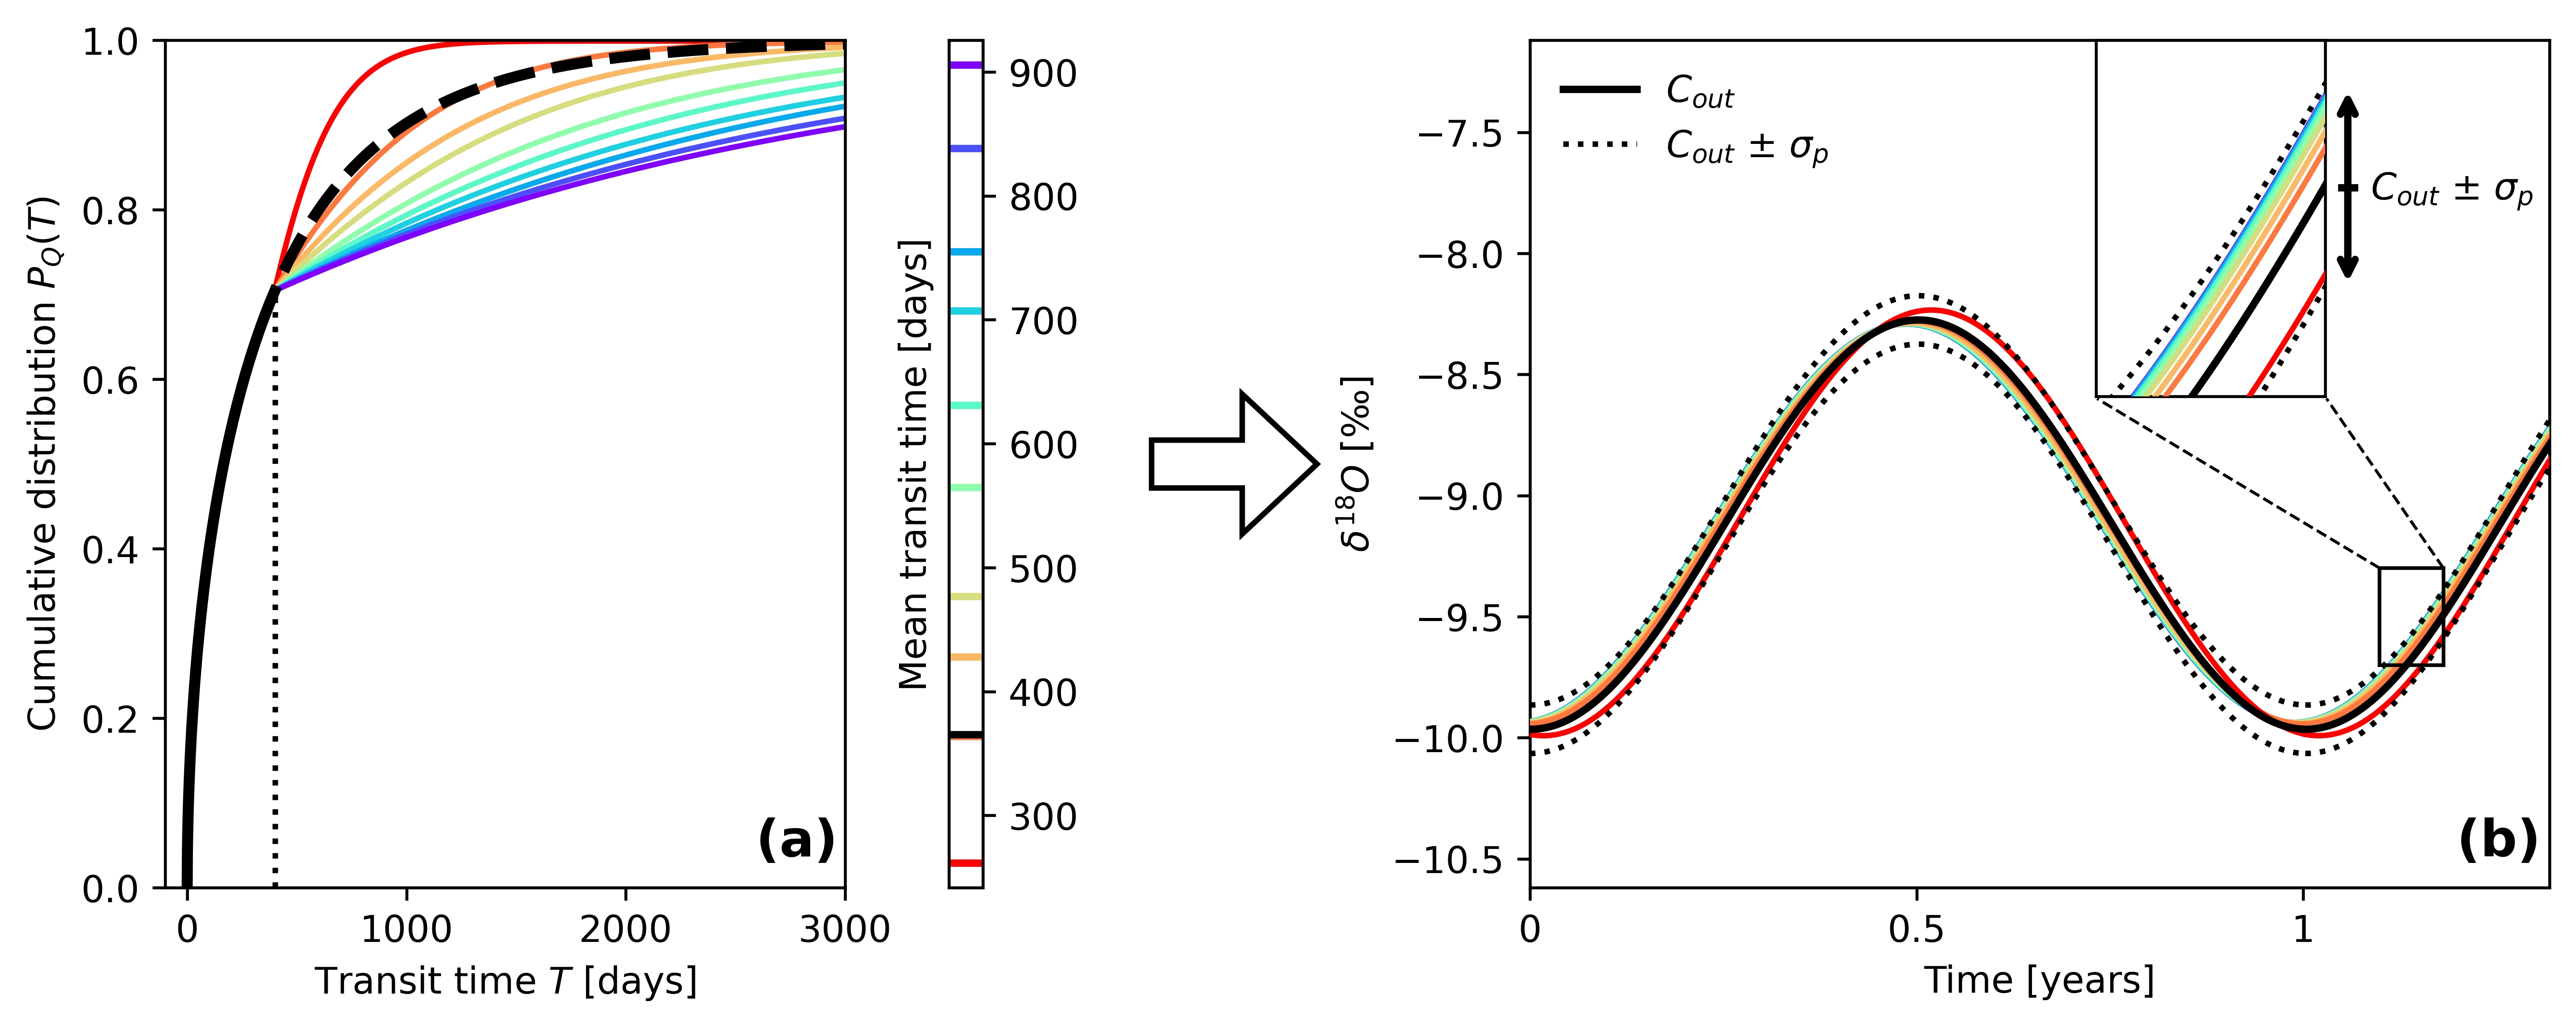

In [7]:
# Define color map based on plotting_MTT values
color = cm.rainbow_r(
    (piecewise_MTT[idx_tails_plot] - piecewise_MTT[idx_tails_plot[0]]) / (piecewise_MTT[idx_tails_plot[-1]] - piecewise_MTT[idx_tails_plot[0]])
)

# Create a 1x3 grid for the subplots
fig = plt.figure(figsize=(10, 4), dpi=600)

# Create a 1x4 grid for the subplots, with the third column as a spacer
gs = gridspec.GridSpec(1, 4, width_ratios=[4, 0.2, 2, 6], wspace=0.2)

# Adjust spacing to bring subplots closer together
fig.subplots_adjust(left=0.05, right=.95, top=0.9, bottom=0.1)

# First subplot for the first figure
ax1 = fig.add_subplot(gs[0])

# Second subplot for the colorbar
cbar_ax = fig.add_subplot(gs[1])

# Third subplot for the arrow (spacer)
arrow_ax = fig.add_subplot(gs[2])
arrow_ax.axis("off")
arrow_ax.arrow(0.03, 0.01, 0.07, 0, head_width=0.003, head_length=0.03, linewidth=3, color='k', length_includes_head=True)
arrow_ax.set_xlim(0, 0.15)
arrow_ax.set_ylim(0, 0.02)

arrow_ax = fig.add_subplot(gs[2])
arrow_ax.axis("off")
arrow_ax.arrow(0.03, 0.01, .07, 0, head_width=0.003, head_length=0.03, linewidth=0, color='white', length_includes_head=True)
arrow_ax.set_xlim(0, 0.15)
arrow_ax.set_ylim(0, 0.02)

# Fourth subplot for the second figure
ax2 = fig.add_subplot(gs[3])

# First figure
for j, arg in enumerate(idx_tails_plot):
    ax1.plot(agesteps[threshold_age:], np.cumsum(piecewise_TTD[arg, :])[threshold_age:], c=color[j])
ax1.plot(cdf_values_ref[:threshold_age], c='k', linewidth=3)
ax1.plot(agesteps[threshold_age+40:], cdf_values_ref[threshold_age+40:-1], c='k', linestyle='dashed', linewidth=3)
ax1.vlines(ymin=0, ymax=cdf_values_ref[threshold_age], x=400, linestyles='dotted', colors='k')
ax1.set_xlim([-100, 3000])
ax1.set_ylim([0, 1])
ax1.set_xlabel(r'Transit time $T$ [days]')
ax1.set_ylabel(r'Cumulative distribution $P_Q(T)$')

# Second figure
# plot twice in series to be onger than one period
for j, arg in enumerate(idx_tails_plot):
    ax2.plot(np.arange(0, 365), Cout_infered_tail[arg, :], c=color[j], zorder=10-j)
    ax2.plot(np.arange(365, 2 * 365), Cout_infered_tail[arg, :], c=color[j], zorder=10-j)

ax2.plot(np.arange(0, 365), Cout_true_one_period, c='k', linewidth=2, zorder=15, label=r'$C_{out}$')
ax2.plot(np.arange(0, 365), Cout_true_one_period + sigma_p, c='k', linestyle='dotted', zorder=15, label=r'$C_{out}$ ± $\sigma_p$')
ax2.plot(np.arange(0, 365), Cout_true_one_period - sigma_p, c='k', linestyle='dotted', zorder=15)
ax2.plot(np.arange(365, 2 * 365), Cout_true_one_period, c='k', zorder=15, linewidth=2)
ax2.plot(np.arange(365, 2 * 365), Cout_true_one_period + sigma_p, c='k', linestyle='dotted', zorder=15)
ax2.plot(np.arange(365, 2 * 365), Cout_true_one_period - sigma_p, c='k', linestyle='dotted', zorder=15)

ax2.legend(loc='upper left', frameon=False)
xticks = np.arange(0, int(2 * 365.25) + 1, int(365.25 / 2))
ax2.set_xticks(xticks)
ax2.set_xticklabels(['0', '0.5', '1', '1.5', '2'])
ax2.set_xlim(xmin=0, xmax=480)
ax2.set_ylim(ymin=k_p - 1.5, ymax=k_p + 2)
ax2.set_ylabel('$\delta^{18}O$ [‰]')
ax2.set_xlabel('Time [years]')

# MTT colorbar figure
norm = mcolors.Normalize(vmin=np.minimum(piecewise_MTT[idx_tails_plot[0]], num_days_in_year)-20, vmax=piecewise_MTT[idx_tails_plot[-1]]+20)
sm = cm.ScalarMappable(cmap=mcolors.ListedColormap(["white"]), norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation="vertical")
cbar.set_label('Mean transit time [days]')
cbar.ax.yaxis.set_label_position("left")  # Label on the left
cbar.ax.yaxis.set_ticks_position("right")  # Tick labels on the right

for value, color_ in zip(piecewise_MTT[idx_tails_plot], color):
    cbar.ax.axhline(y=value,
                    color=color_, linewidth=2)
cbar.ax.axhline(y=num_days_in_year, color='k', linewidth=2)

# Second figure inset
inset_ax = inset_axes(ax2, width="90%", height="70%", 
                      bbox_to_anchor=(0.53, 0.4, 0.25, 0.6), 
                      bbox_transform=ax2.transAxes, borderpad=0)

# Now add your zoomed-in plot data in the inset
for j, arg in enumerate(idx_tails_plot):
    for k in range(2):
        inset_ax.plot(np.arange(k * 365, (k + 1) * 365), Cout_infered_tail[arg, :], c=color[j], linewidth=1.5, zorder=10-j)

for k in range(2):
    inset_ax.plot(np.arange(k * 365, (k + 1) * 365), Cout_true_one_period, c='k', linewidth=2, zorder=100)
    inset_ax.plot(np.arange(k * 365, (k + 1) * 365), Cout_true_one_period + sigma_p, c='k', linestyle='dotted', zorder=15)
    inset_ax.plot(np.arange(k * 365, (k + 1) * 365), Cout_true_one_period - sigma_p, c='k', linestyle='dotted', zorder=15)

inset_ax.set_xlim(400, 400 + 30)  # Set x-axis limits for zoomed-in region
inset_ax.set_ylim(-9.7, -9.35)  # Adjust y-axis limits for zoomed-in region

# Remove the tick labels on the inset
inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# Add a rectangle to show where the inset is zooming in
rect_x, rect_width = 400, 30
rect_y, rect_height = -9.7, 0.4  # Set y-range to match inset's y-limits

# Create and add the rectangle to ax2
zoom_rect = Rectangle((rect_x, rect_y), rect_width, rect_height, 
                      linewidth=1, edgecolor='black', linestyle='-', facecolor='none', zorder=20)
ax2.add_patch(zoom_rect)

# Add lines connecting corners
ax2.plot([400, 267], [-9.3, -8.6], color="black", linewidth=.8, linestyle='--')
ax2.plot([400 + 30, 375], [-9.3, -8.6], color="black", linewidth=.8, linestyle='--')

# Add a double-sided arrow with an annotation
ax2.annotate(
    text='',
    xy=(385, -7.3),  # End of the arrow
    xytext=(385, -8.15),  # Start of the arrow
    arrowprops=dict(arrowstyle='<->', color='black', lw=2)  # Double-sided arrow
)

# Add annotation text next to the arrow
ax2.annotate(
    text=r'$C_{out}$ ± $\sigma_p$',
    xy=(394, -7.66),  # Position of the annotation text
    xytext=(1, -7.68),  # Same position
    textcoords='offset points',  # Adjust relative to the position
    fontsize=10, color='black'
)

# Add a tick at the midpoint
tick_length = 3  # Adjust tick length
ax2.plot([385 - tick_length, 385 + tick_length], [-7.728, -7.728], color='black', lw=2)

fig.text(0.273, 0.13, '(a)', fontsize=14, weight='bold', transform=plt.gcf().transFigure)
fig.text(0.915, 0.13, '(b)', fontsize=14, weight='bold', transform=plt.gcf().transFigure)

fig.tight_layout()